# PSO_Optimization_of_lens_model_DESIJ1101_0602

Authors: Janntul Feardous, Anowar J. Shajib


Acknowledgement:Sulyman Hossain

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

ModuleNotFoundError: ignored

In [4]:
try:
    import corner
except:
    !pip install corner

try:
    import lenstronomy
except:
    !pip install lenstronomy

try:
    import emcee
except:
    !pip install emcee

try:
    import cobaya
except:
    !pip install cobaya

import h5py
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util import mask_util, util

%matplotlib inline

<ipython-input-5-2c2e9b0c088b>:10: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");


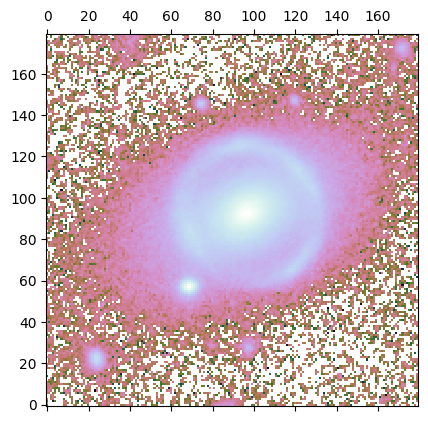

In [5]:
# data specifics

with h5py.File("/content/drive/MyDrive/BDlensing_Nishii/DESIJ1101-0602_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

image_data = kwargs_data["image_data"]
kwargs_data
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");

In [6]:
with h5py.File("/content/drive/MyDrive/BDlensing_Nishii/psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

In [7]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
# beta, n_max, center_x, center_y
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

<ipython-input-8-44046f4e6dba>:95: RuntimeWarning: divide by zero encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)
<ipython-input-8-44046f4e6dba>:95: RuntimeWarning: invalid value encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)


Text(0.5, 1.0, 'IMAGE AFTER MASKING')

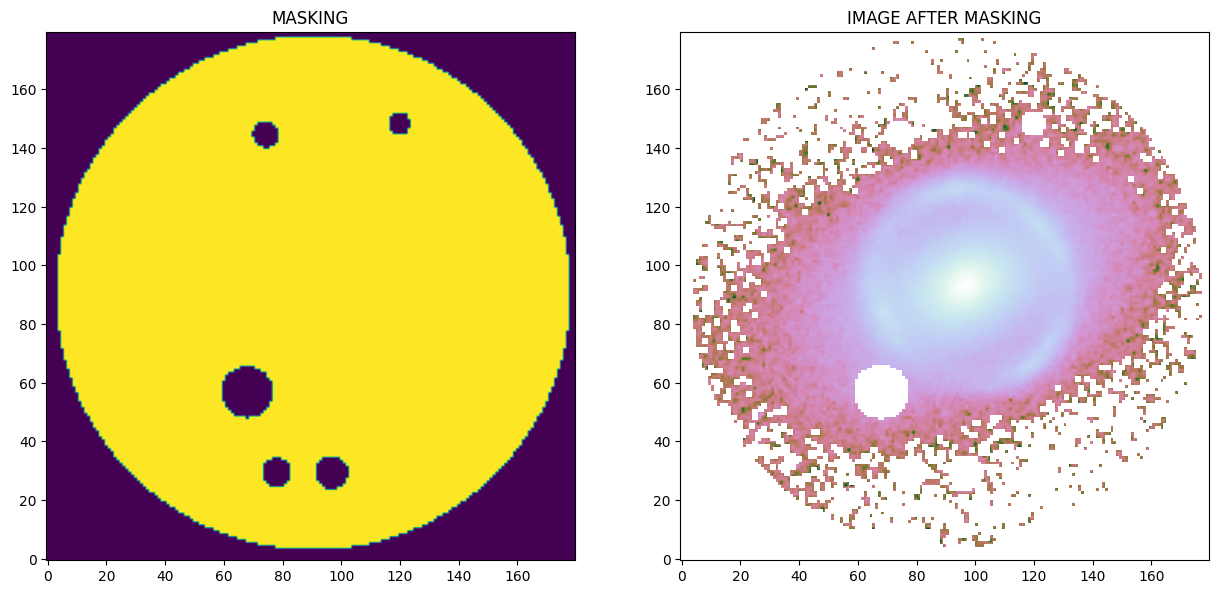

In [8]:
# To make a mask using lenstronomy functions:


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r1 = 7  # arcsecond
lens_center_ra = 0
lens_center_dec = 0

mask_outer_1 = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r1,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

# mask_outer_2 = mask_util.mask_center_2d(
#     lens_center_ra,
#     lens_center_dec,
#     r2,
#     util.image2array(x_coords),
#     util.image2array(y_coords),)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.8,
    lens_center_dec - 2.7,
    0.7,
    0.7,
    0,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.34,
    lens_center_dec + 4.6,
    0.3,
    0.3,
    0,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.3,
    lens_center_dec + 4.3,
    0.35,
    0.35,
    0,
)
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5,
    lens_center_dec - 4.9,
    0.45,
    0.45,
    0,
)
mask_ext_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1,
    lens_center_dec - 4.9,
    0.4,
    0.4,
    0,
)

mask_1 = (1 - mask_outer_1) * (1 - mask_ext_1)
mask_2 = (1 - mask_ext_2) * (1 - mask_ext_3)
mask_3 = (1 - mask_ext_4) * (1 - mask_ext_5)
mask1 = mask_1 * mask_2 * mask_3
mask1[mask1 >= 1] = 1

mask1[mask1 < 0] = 0


mask_img = mask1.reshape(num_pix, num_pix)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))


image = np.log10(kwargs_data["image_data"] * mask_img)


plt.sca(axs[0])
plt.imshow(mask_img, origin="lower")
plt.title("MASKING")
# plt.colorbar()


# plt.matshow(np.log10(image), origin="lower", cmap="cubehelix")


plt.sca(axs[1])
plt.imshow(image, origin="lower", cmap="cubehelix")
plt.title("IMAGE AFTER MASKING")

In [ ]:
# lens galaxy's mass model

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# Setting EPL Parameters

fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 2.6298,
        "gamma": 2.0,
        "e1": 0.1180,
        "e2": -0.1393,
        "center_x": -0.4889,
        "center_y": 0.2082,
    }
)
kwargs_lens_sigma.append(
    {
        "gamma": 0.1,
        "theta_E": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
    }
)
kwargs_lower_lens.append(
    {
        "gamma": 1.9,
        "theta_E": 1.0,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "gamma": 3.0,
        "theta_E": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)


# Setting SHEAR Parameters

fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": 0.0308, "gamma2": -0.0167})
kwargs_lens_sigma.append({"gamma1": 0.05, "gamma2": 0.05})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

In [ ]:
# lens galaxy's light model


fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "amp": 1,
        "R_sersic": 1.9266,
        "n_sersic": 4.0,
        "e1": 0.1180,
        "e2": -0.1393,
        "center_x": -0.4889,
        "center_y": 0.2082,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.1,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 3.0,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# sersic_2


fixed_lens_light.append({"n_sersic": 1.0})
kwargs_lens_light_init.append(
    {
        "amp": 1,
        "R_sersic": 1.2749,
        "n_sersic": 1.0,
        "e1": 0.1797,
        "e2": -0.1808,
        "center_x": -0.4889,
        "center_y": 0.2082,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.1,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 3.0,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# joint_lens_with_light = [[0, 0, ["center_x", "center_y", "e1", "e2"]]]
joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

In [ ]:
# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "amp": 1,
        "R_sersic": 0.0979,
        "n_sersic": 1.0,
        "e1": 0.065304688741,
        "e2": -0.109524,
        "center_x": -0.5863734,
        "center_y": 0.160918082,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.008,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.01,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.2,
        "n_sersic": 2.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# add shapelets model to this source model
fixed_source.append({"n_max": 10})
kwargs_source_init.append(
    {"beta": 0.0517, "center_x": -0.586371, "center_y": 0.1609180}
)
kwargs_source_sigma.append({"beta": 0.001, "center_x": 0.1, "center_y": 0.1})
kwargs_lower_source.append({"beta": 0.03, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.2, "center_x": 10, "center_y": 10})

joint_source_with_shapelet = [[0, 1, ["center_x", "center_y"]]]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

In [ ]:
# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_source_with_shapelet,
}
kwargs_likelihood = {
    "check_bounds": True,
    "image_likelihood_mask_list": [mask_img],
}

kwargs_numerics = {
    "supersampling_factor": 1,
    "supersampling_convolution": False,
}
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [
    [
        kwargs_data,
        kwargs_psf,
        kwargs_numerics,
    ]
]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

In [ ]:
fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 50, "n_iterations": 100}]
]
# ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
# 200, 'sigma_scale': .1}]

fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    mpi=False,
    verbose=True,
)

input_ = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
]

fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list

kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs


# fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
# kwargs_constraints, kwargs_likelihood, kwargs_params)

# fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 400,
#'n_iterations': 700}],
# ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
# 200, 'sigma_scale': .1}]]

# chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
# kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
PSO: Exception while calling your likelihood function:
  params: [2.71319226949584, 1.9962672164207342, 0.12713317367478297, -0.11841117580349363, -0.5004788573403903, 0.16527665874639386, 0.023453144883846373, -0.032324884330732, 0.10369817028460374, 0.11384158670721219, -0.08925228807135904, -0.5213926219208802, 0.18561696864896937, 0.05244300662380374, 1.8212491796308488, 0.1017058483035151, -0.1491868978345919, -0.5525280390234065, 0.2836877299259889, 1.2348154646203018]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/lenstronomy/Sampling/Samplers/pso.py", line 466, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/lenstronomy/Sampling/likelihood.py", line 314, in logL
    return self.log_likelihood(kwargs_return, verbose=verbose)
  File "/usr/local/lib/python3.10/dist-packages/lenstronomy/Sampling/likelihood.py", line 344, in log_likelihood
    logL_image = self.image_likelihood.logL(**kwargs_return)
  File "/usr/local/lib/python3.10/dist-packages/lenstronomy/Sampling/Likelihoods/image_likelihood.py", line 73, in logL
    logL = self.imSim.likelihood_data_given_model(
  File "/usr/local/lib/python3.10/dist-packages/lenstronomy/ImSim/MultiBand/single_band_multi_model.py", line 334, in likelihood_data_given_model
    return self._likelihood_data_given_model(
  File "/usr/local/lib/python3.10/dist-packages/lenstronomy/ImSim/image_linear_solve.py", line 408, in _l

KeyboardInterrupt: ignored

In [ ]:
init_samples = None


output = [
    kwargs_result,
    multi_band_list_out,
    fit_output,
    kwargs_fixed_out,
]


input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output_path = "PSO Optimization of lens_model_DESIJ1101-0602.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

output_path

'PSO Optimization of lens_model_DESIJ1101-0602.joblib'

-1.1008071206361203 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.1008071206361192


E:\Anaconda\lib\site-packages\lenstronomy\Plots\model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
E:\Anaconda\lib\site-packages\lenstronomy\Plots\model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
E:\Anaconda\lib\site-packages\lenstronomy\Plots\model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
C:\Users\Dell\AppData\Local\Temp\ipykernel_11324\4000457043.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


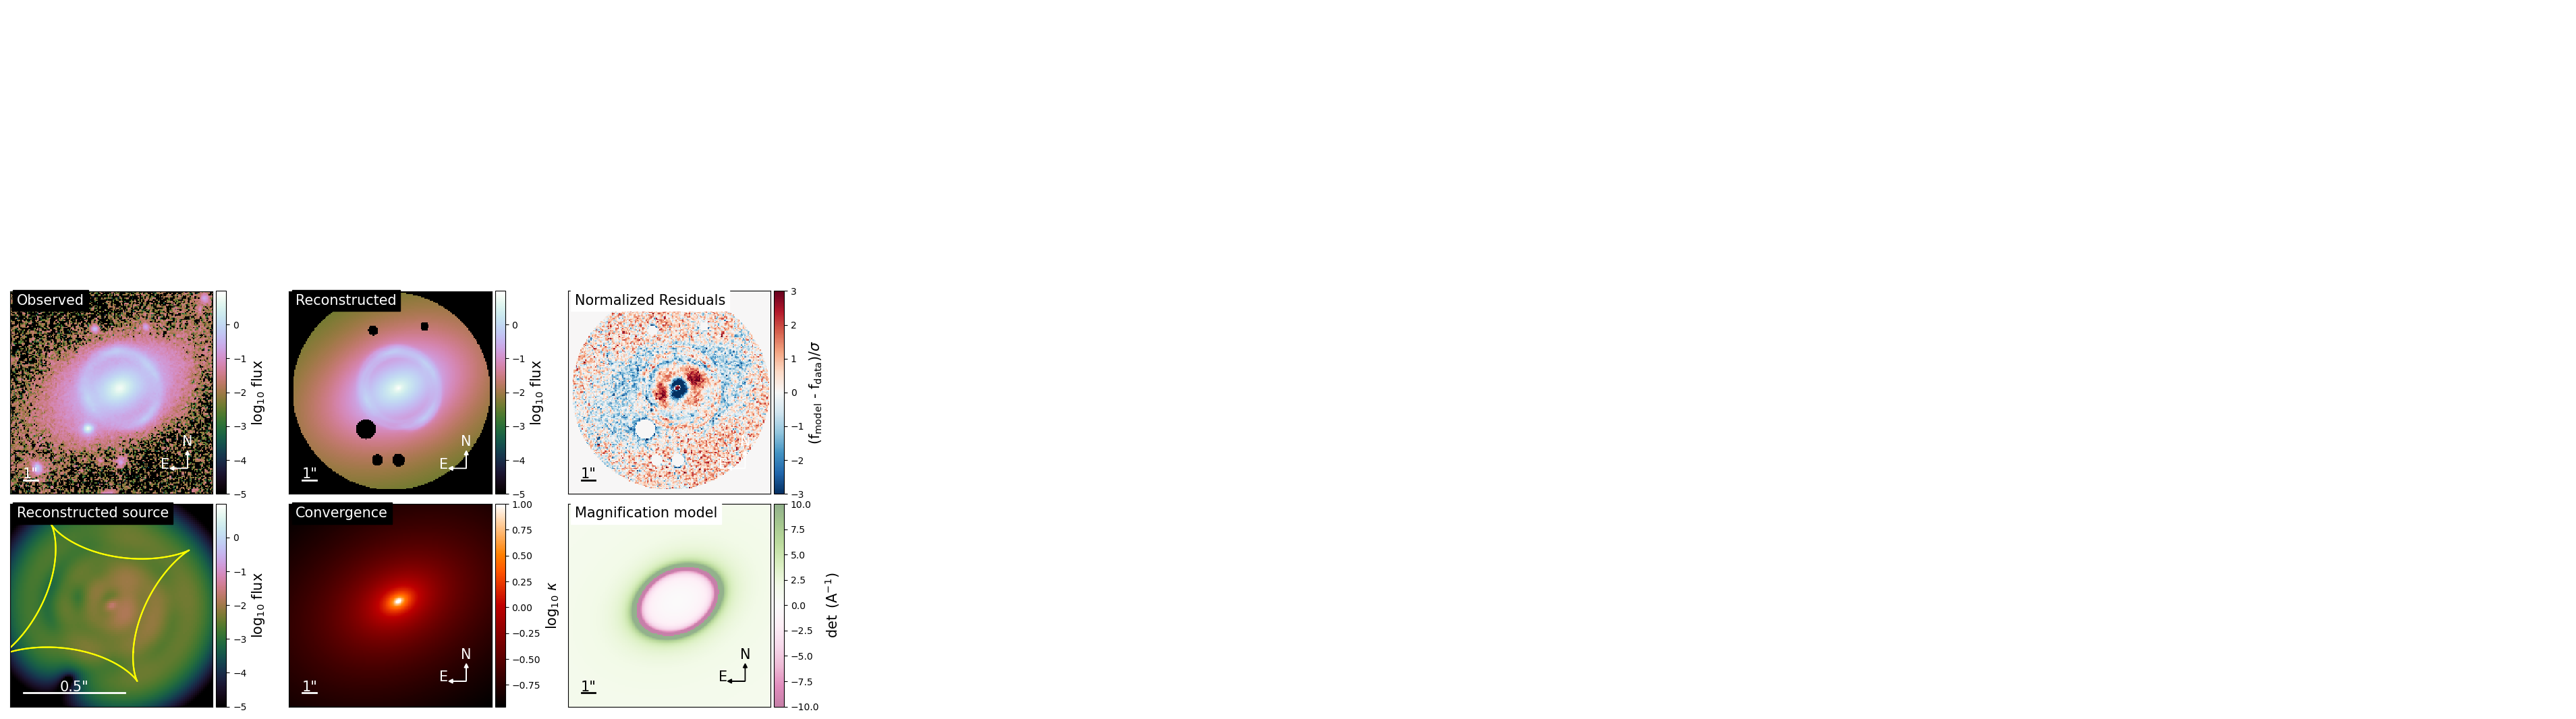

E:\Anaconda\lib\site-packages\lenstronomy\Plots\model_band_plot.py:506: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,
E:\Anaconda\lib\site-packages\lenstronomy\Plots\model_band_plot.py:506: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


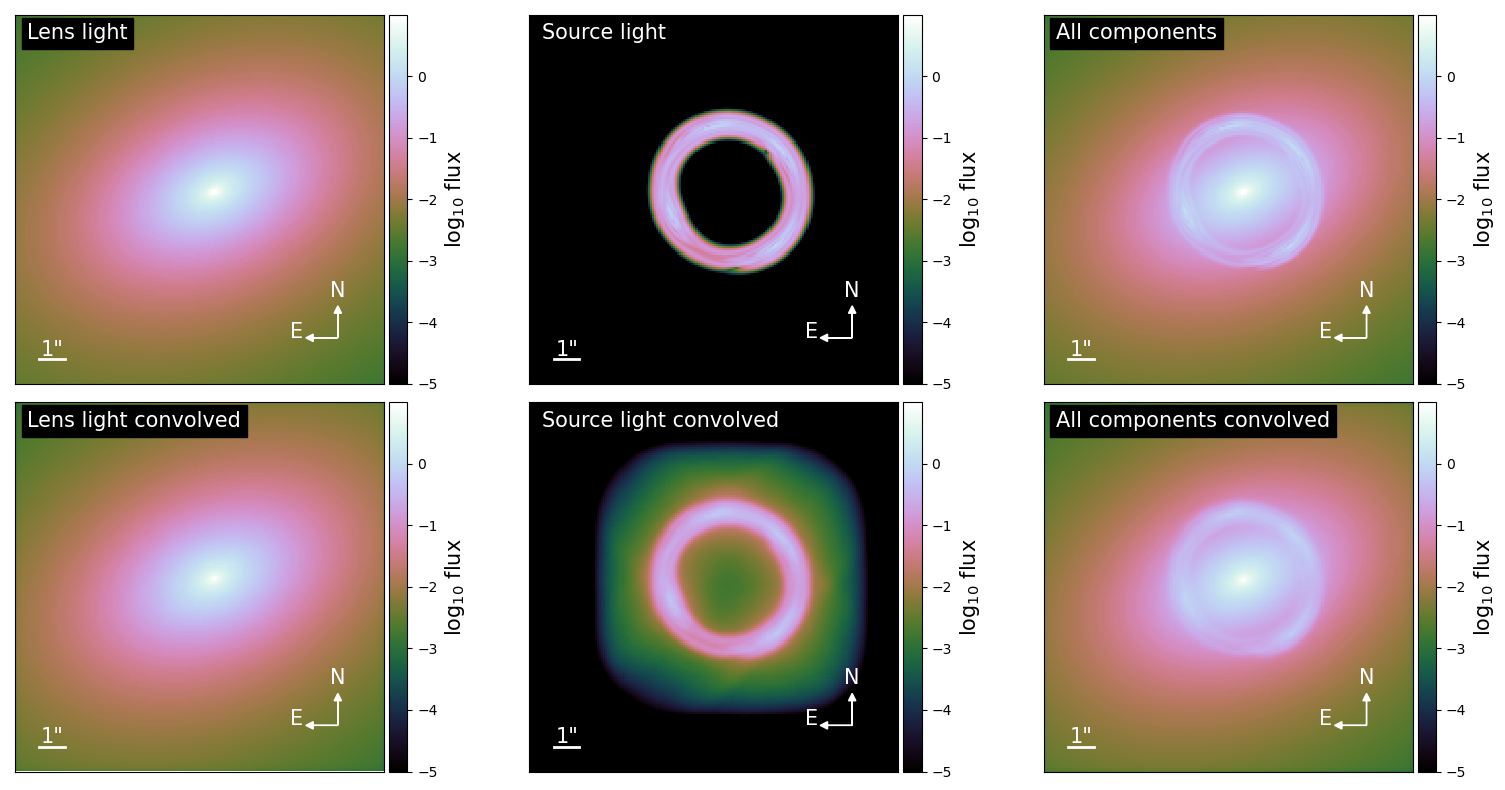

{'kwargs_lens': [{'theta_E': 2.6319947800728527, 'gamma': 2.0, 'e1': 0.11863258807974596, 'e2': -0.14683320822011373, 'center_x': -0.48787606296819874, 'center_y': 0.20617985881153633}, {'gamma1': 0.030543834011443043, 'gamma2': -0.020460695605256943, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.03281044737799597, 'n_sersic': 1.0, 'e1': 0.09755941586725274, 'e2': -0.11171345725926216, 'center_x': -0.5528265313998123, 'center_y': 0.19182032941012936}, {'amp': 1, 'n_max': 10, 'beta': 0.0999852858558037, 'center_x': -0.5528265313998123, 'center_y': 0.19182032941012936}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 2.0038827906622974, 'n_sersic': 4.0, 'e1': 0.11863258807974596, 'e2': -0.14683320822011373, 'center_x': -0.48787606296819874, 'center_y': 0.20617985881153633}, {'amp': 1, 'R_sersic': 1.2514209165082022, 'n_sersic': 1.0, 'e1': 0.1783102604290082, 'e2': -0.1730172640626838, 'center_x': -0.48787606296819874, 'center_y': 0.20617985881153633}], 'kwargs_ps': []

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.01, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

In [ ]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

mcmc_backend = "/content/drive/MyDrive/BDlensing_Nishii/mcmc_backend.h5"


n_walkers = 80
n_step = 500
n_burn = 0

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": n_burn,
            "n_run": n_step,
            "n_walkers": n_walkers,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,

        },
    ]
]

fitting_seq_mcmc = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)

100%|██████████| 500/500 [2:50:39<00:00, 20.48s/it]

Computing the MCMC...
Number of walkers =  80
Burn-in iterations:  0
Sampling iterations (in current run): 500
10241.499145030975 time taken for MCMC sampling


In [ ]:
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()

In [ ]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

    # Alternatively, you can access the last chain directly
    last_chain = chain_list_mcmc[-1]
    last_samples = last_chain[1]
    last_param_names = last_chain[2]
    print("Last Chain:")
    print("Sampler type:", last_chain[0])
    print("Parameter names:", last_param_names)
    print("Shape of samples:", last_samples.shape)
else:
    print("No MCMC chains available.")

Chain 1:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Shape of samples: (118480, 20)

Last Chain:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Shape of samples: (118480, 20)


(118480, 20)
N_step: 1481, N_walkers: 80, N_params: 20


<ipython-input-16-89c1e155483b>:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


theta_E_lens0 2.6353 ± 0.0026
gamma_lens0 1.5013 ± 0.0010
e1_lens0 0.0985 ± 0.0018
e2_lens0 -0.1112 ± 0.0033
center_x_lens0 -0.4778 ± 0.0033
center_y_lens0 0.2138 ± 0.0031
gamma1_lens1 0.0592 ± 0.0013
gamma2_lens1 -0.0555 ± 0.0023
R_sersic_source_light0 0.1038 ± 0.0010
e1_source_light0 0.1467 ± 0.0150
e2_source_light0 -0.2609 ± 0.0066
center_x_source_light0 -0.4789 ± 0.0037
center_y_source_light0 0.1857 ± 0.0043
beta_source_light1 0.0547 ± 0.0002
R_sersic_lens_light0 2.2943 ± 0.0261
e1_lens_light0 0.1451 ± 0.0013
e2_lens_light0 -0.1584 ± 0.0010
center_x_lens_light0 -0.4858 ± 0.0009
center_y_lens_light0 0.1954 ± 0.0014
R_sersic_lens_light1 1.1191 ± 0.0066


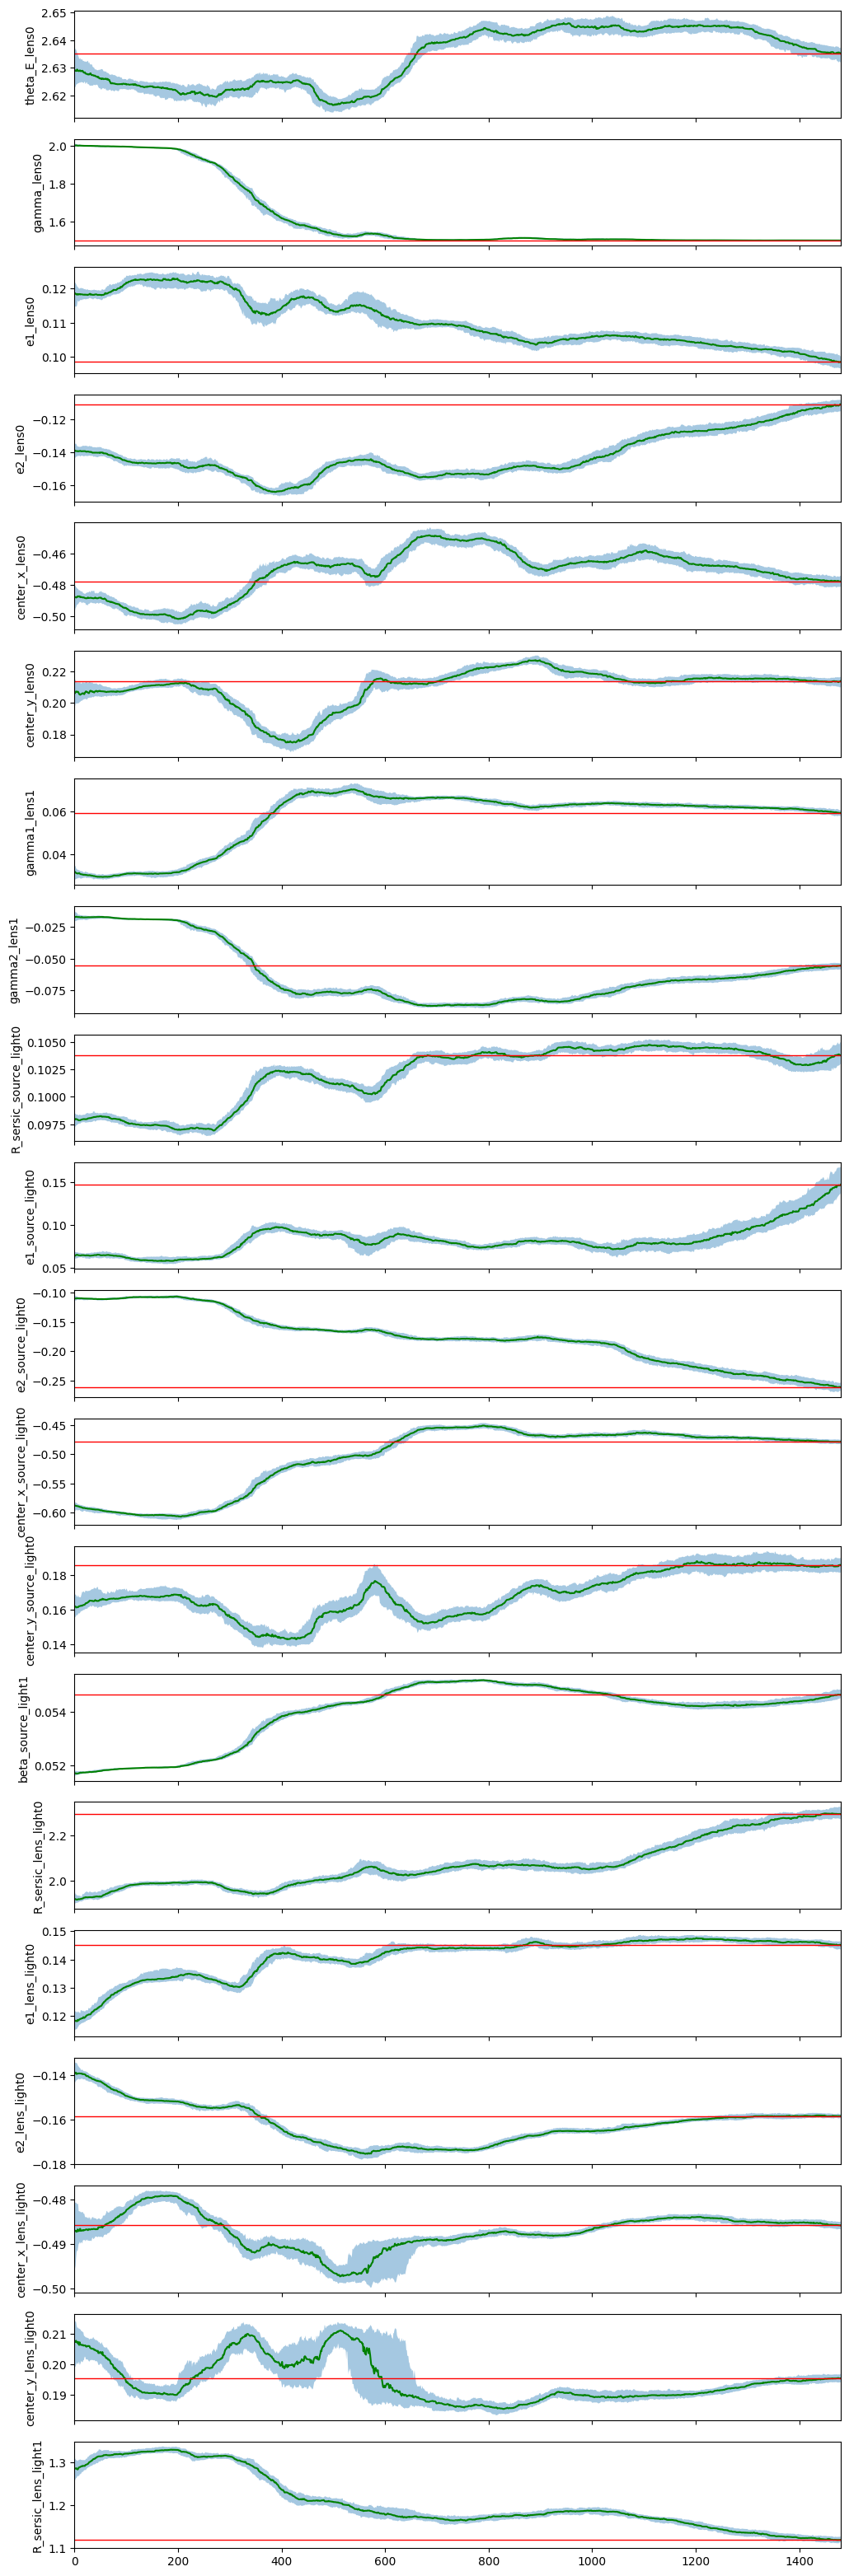

In [ ]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != 'PSO':
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc)-mcmc_repeat, len(chain_list_mcmc)):
        if samples_mcmc == []:
            samples_mcmc = chain_list_mcmc[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, chain_list_mcmc[k][1]))

        param_mcmc = chain_list_mcmc[k][2]

print(samples_mcmc.shape)

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]
    n_walkers = 80
    n_step = int(samples_mcmc.shape[0] / n_walkers)
    n_burn = 0

    print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step,
                                                           n_walkers,
                                                           n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order='F')
        chain[:,:,i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1],
                    (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1],
                    (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(param_mcmc[i],
              '{:.4f} ± {:.4f}'.format(median_pos[i][last-1],
               (q84_pos[i][last-1]-q16_pos[i][last-1])/2))

        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last),
                           q84_pos[i][:last],
                           q16_pos[i][:last],
                           alpha=0.4)

        ax[i].set_ylabel(param_mcmc[i],
                         fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        plt.show()

In [ ]:
import corner

if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 1000
        thin = 5
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

Output hidden; open in https://colab.research.google.com to view.

-1.0543832570489193 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0543832570489258


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
<ipython-input-20-25e04ed0a5e7>:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


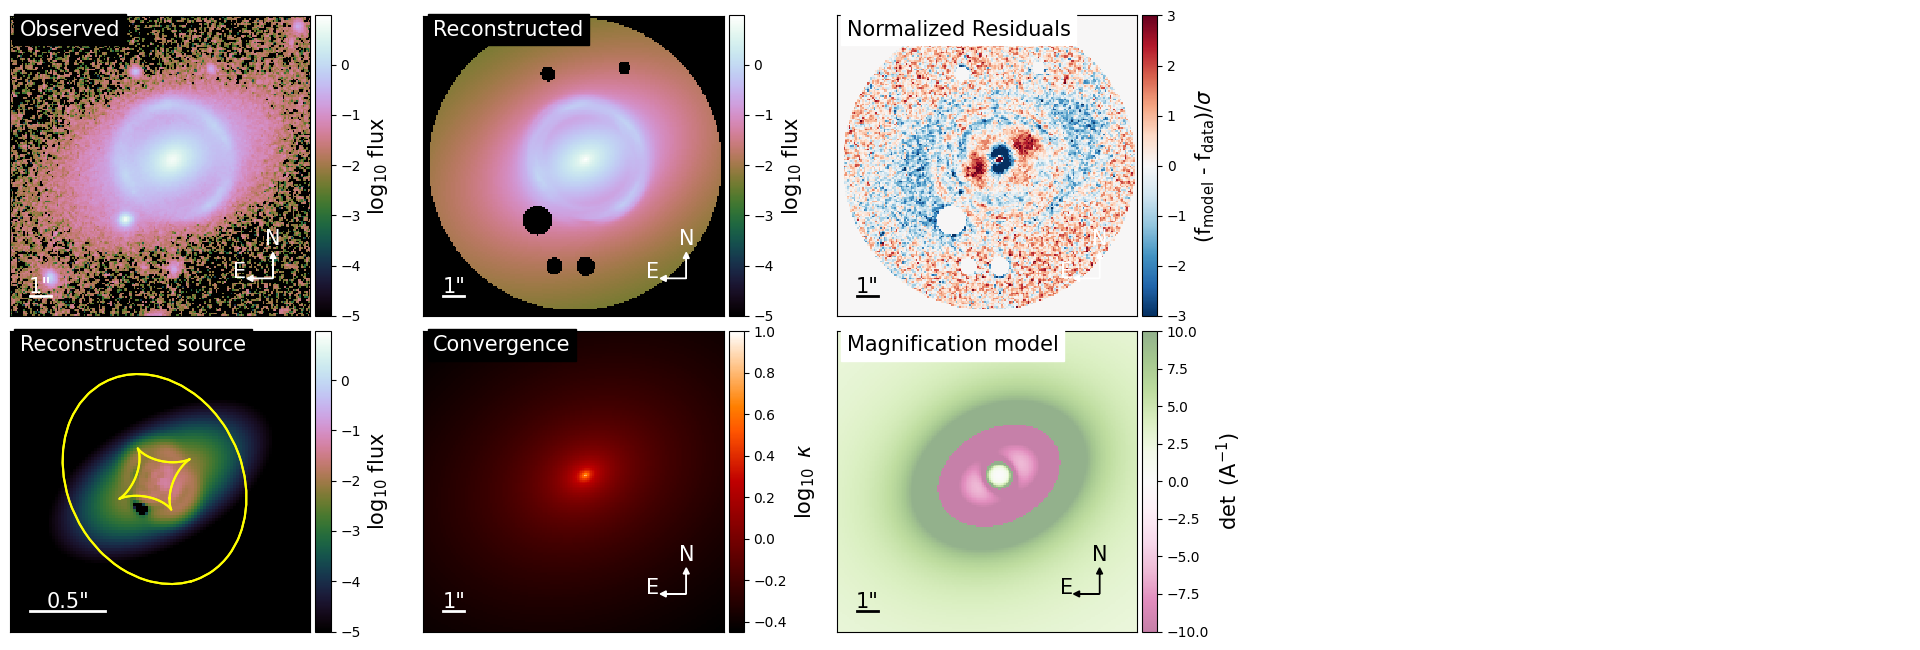

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


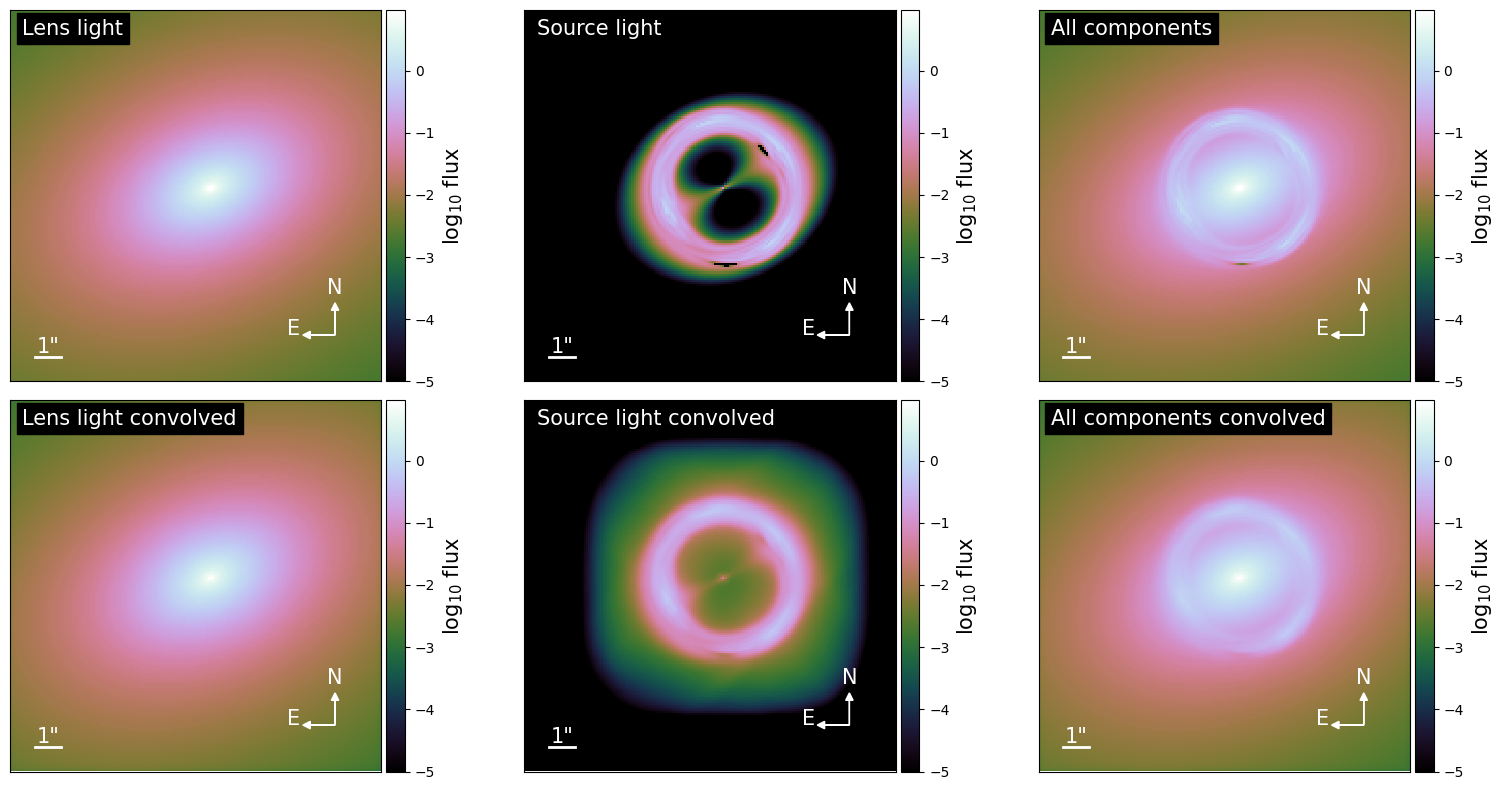

{'kwargs_lens': [{'theta_E': 2.6355372940864834, 'gamma': 1.5007141895330673, 'e1': 0.09661806878673905, 'e2': -0.11275349551237948, 'center_x': -0.4778588710437482, 'center_y': 0.21199788864134983}, {'gamma1': 0.057796567621532936, 'gamma2': -0.056558753777179165, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 66.09574068691325, 'R_sersic': 0.1041757268238882, 'n_sersic': 1.0, 'e1': 0.16879548733679, 'e2': -0.2694539953948339, 'center_x': -0.4762637314269732, 'center_y': 0.18241595322140688}, {'amp': array([-236.82018684,  -73.43964794,    7.19852085,   -3.50731159,
         90.81798854,   74.89379207,  -18.66775898,   -9.86469584,
        -13.14353177,    4.03327636,  -15.170749  ,   36.26630956,
         -2.76829588,   -7.38751986,    8.47763046,  -31.8665674 ,
         -6.79960238,  -12.44966794,   -3.6732776 ,  -13.97337319,
         -1.6456693 ,   19.44622593,   22.77557906,   -2.51436054,
         33.56246384,   22.07802542,   31.91934424,   27.15628305,
         -9.83233552

In [ ]:
from lenstronomy.Plots.model_plot import ModelPlot

model_plot = ModelPlot(
    multi_band_list, kwargs_model, kwargs_result_mcmc,
    arrow_size=0.02, cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list'],
    linear_solver=kwargs_constraints.get('linear_solver', True)
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(
    ax=axes[0, 2], v_min=-3, v_max=3, cmap='RdBu_r'
)
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02,
    numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')
f.tight_layout()
f.subplots_adjust(
    left=None, bottom=None, right=None,
    top=None, wspace=0., hspace=0.05
)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text='Lens light', lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text='Lens light convolved', lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text='Source light', source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text='Source light convolved', source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2], text='All components', source_add=True,
    lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 2], text='All components convolved', source_add=True,
    lens_light_add=True, point_source_add=True
)
f.tight_layout()
f.subplots_adjust(
    left=None, bottom=None, right=None,
    top=None, wspace=0., hspace=0.05
)
plt.show()
print(kwargs_result_mcmc)

In [ ]:
import joblib

multi_band_list_out = fitting_seq_mcmc.multi_band_list
kwargs_fixed_out = fitting_seq_mcmc.kwargs_fixed

init_samples = n_step  # can be not `None` for MCMC

input = [fitting_kwargs_list_mcmc,
         multi_band_list,
         kwargs_model,
         kwargs_constraints,
         kwargs_likelihood,
         kwargs_params,
         init_samples]

output = [kwargs_result_mcmc,
          multi_band_list_out,
          kwargs_fixed_out]

output_path = f'/content/drive/MyDrive/BDlensing_Project/DESIJ0201-2739_mcmc_output.joblib'

with open(output_path, 'wb') as f:
    joblib.dump([input, output], f, compress=True)